In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import csv

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-02-05 17:45:24.953164: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def sample_loader(dataset, split):
  data = tfds.load(dataset, split=split)
  data = data.map(lambda x: (x['image'], x['mask']))
  return tfds.as_numpy(data)

def batch_loader(dataset, split, batch_size):
  do_shuffle = (split == 'train')
  data = tfds.load(dataset, split=split, shuffle_files=do_shuffle)
  data = data.map(lambda x: (x['image'] / 255, x['mask'] > 0))
  if do_shuffle:
    data = data.shuffle(1024 * 16)
  data = data.batch(batch_size)
  return data

def show_sample(sample, img_index):
  image, mask = sample
  mask = np.concatenate([mask]*3, axis=-1)
  viz = np.concatenate([image, mask], axis=1)
  # display(Image.fromarray(viz))
  imgviz = Image.fromarray(viz)
  imgviz.save(f'/root/workspace_private/example_images/image_test_{img_index}.png')

coasts_ds = sample_loader('coastlines', 'test')
n_samples = len(coasts_ds)
coasts_iter = iter(coasts_ds)

# glaciers_ds = sample_loader('glaciers', 'train')
# glaciers_iter = iter(glaciers_ds)

2024-02-05 17:45:30.519724: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 17:45:30.868651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22074 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


In [18]:
import random
from itertools import islice
import matplotlib.pyplot as plt

for i in range(15):
    img_index = random.randint(1, len(coasts_ds))
    sample = list(islice(coasts_ds, img_index-1, img_index))
    show_sample(sample[0], img_index)
    
    # img, msk = sample[0]

    # msk = np.concatenate([msk]*3, axis=-1)

    # image = Image.fromarray(img)
    # mask = Image.fromarray(msk)

    # image.save(f'/root/workspace_private/example_images/image_test_{img_index}.png')
    # mask.save(f'/root/workspace_private/example_images/mask_test_{img_index}.png')


In [13]:
# Check class balance
N_pixels = 512*512
coast_pixels_list = []

for i in range(n_samples):
    image, mask = next(coasts_iter)
    coast_pixels = int(np.sum(mask.flatten())/255)
    coast_pixels_list.append(coast_pixels)
    
cpixels_mean = np.mean(coast_pixels_list)
print(f'Class balance: {100 * cpixels_mean/N_pixels:3.2f}% are coast pixels, {100 * (1 - cpixels_mean/N_pixels):3.2f}% are water pixels')

Class balance: 48.26% are coast pixels, 51.74% are water pixels


98
31
88
22


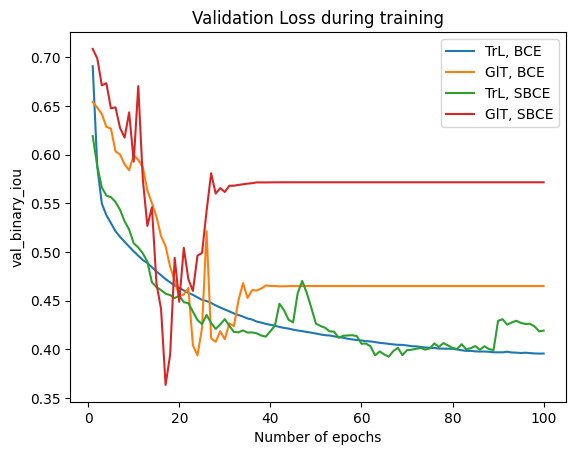

In [13]:
# Plot training accutacies

file_list = ['cd_model_logs2_pretrain_compl', 'glacier_model_logs2', 'cd_model_logs12_pretrain_compl', 'glacier_model_logs12']
labels = ['TrL, BCE', 'GlT, BCE', 'TrL, SBCE', 'GlT, SBCE']

plt.figure()
for i, fname in enumerate(file_list): 
    val_acc_list = []
    val_IoU_list = []
    val_loss_list = []
    file = open(f'/root/workspace_private/trained_models/{fname}.csv')
    logdata = csv.reader(file)
    next(logdata)   # skip header

    for row in logdata:
        val_acc_list.append(float(row[7]))
        val_IoU_list.append(float(row[8]))
        val_loss_list.append(float(row[9]))

    epochs = np.arange(1, len(val_loss_list)+1)
    print(np.argmax(val_IoU_list))

    plt.plot(epochs, val_loss_list, label=labels[i])
plt.legend()
plt.title('Validation Loss during training')
plt.xlabel('Number of epochs')
plt.ylabel('val_binary_iou')
plt.savefig(f'/root/workspace_private/val_loss_models.png')
plt.show()

<Figure size 640x480 with 0 Axes>

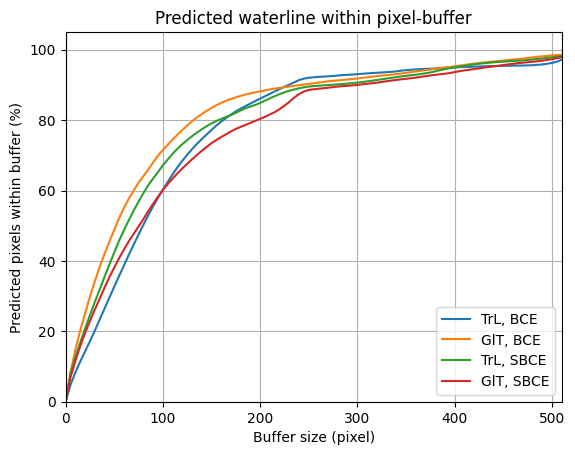

In [5]:
# plot overall spatial accuracy for the models

# Plot training accutacies

buffer_list = np.arange(0, 512, 5)

file_list = ['coastDetection_TrL_BCE_buffers', 'glacierDetection_BCE_buffers', 'coastDetection_TrL_SBCE_buffers', 'glacierDetection_SBCE_buffers']
labels = ['TrL, BCE', 'GlT, BCE', 'TrL, SBCE', 'GlT, SBCE']

plt.figure()
fig, ax = plt.subplots(1,1)

for i, fname in enumerate(file_list): 

    model_buffers = np.load(f'/root/workspace_private/{fname}.npy')
    ax.plot(buffer_list, model_buffers, label=labels[i])


ax.grid()
ax.set_ylim(0,105)
ax.set_xlim(buffer_list[0], buffer_list[-1])
plt.legend()
plt.xlabel('Buffer size (pixel)')
plt.ylabel('Predicted pixels within buffer (%)')
# ax.set_xticks(buffer_list)
plt.title("Predicted waterline within pixel-buffer")
plt.savefig(f'/root/workspace_private/buffers_per_model.png')
plt.show()